# Optimizer benchmarks

Run different convex optimizers with different settings on the japan and north america examples to compare accuracy and performance.

In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:
# ffmpeg -framerate 2 -i "state_%04d.png" -c:v libx264 -vf "fps=25,format=yuv420p" annealing_convergence.mp4

In [2]:
%config InlineBackend.figure_format = "retina"
# Relevant for the linear solver faer in clarabel:
%env RAYON_NUM_THREADS=4

env: RAYON_NUM_THREADS=4


In [3]:
import datetime
import itertools

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import tqdm
from loguru import logger

import celeri
import celeri.optimize

logger.disable("celeri")

In [4]:
command_files = {
    "japan": "../data/command/japan_command_cmi_coupling.json",
    "north_america": "../data/command/western_north_america_command_coupling.json",
}

## Run full optimization

### Japan

In [6]:
%%time
problem = celeri.optimize.build_problem(command_files["japan"])

Calculating cutde partials for triangles: 100%|██████████| 76/76 [00:04<00:00, 17.69it/s]


CPU times: user 19min 47s, sys: 7.92 s, total: 19min 55s
Wall time: 5min 55s


In [7]:
#%%time

from celeri.optimize import MinimizerTrace

solve_kwargs = dict(
    solver="CLARABEL",
    equilibrate_enable=False,
    direct_solve_method="faer",
    ignore_dpp=True,
)

trace_japan: MinimizerTrace = celeri.optimize.minimize(
    problem,
    verbose=True,
    velocity_upper=110.0,
    velocity_lower=-110.0,
    solve_kwargs=solve_kwargs,
    objective="qr_sum_of_squares",
    max_iter=100,
    annealing_schedule=[0.125, 0.125, 0.125],
)

Iteration: 1
5133 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 4.21e+06
residual 2-norm: 34.90583079498873
Iteration took 21.15s

Iteration: 2
4186 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.08e+06
residual 2-norm: 37.30332788820176
Iteration took 21.88s

Iteration: 3
2179 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.52e+05
residual 2-norm: 39.97139016711787
Iteration took 20.11s

Iteration: 4
993 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.53e+04
residual 2-norm: 41.337334882338524
Iteration took 23.47s

Iteration: 5
409 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.44e+03
residual 2-norm: 42.095549891960964
Iteration took 20.71s

Iteration: 6
209 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.47e+02
residual 2-norm: 42.311356126764856
Iteration took 20.89s

Iteration: 7
99 of 9508 velocities are out-of-bounds
Non-convex constraint loss: 1.80e+01
residual 2

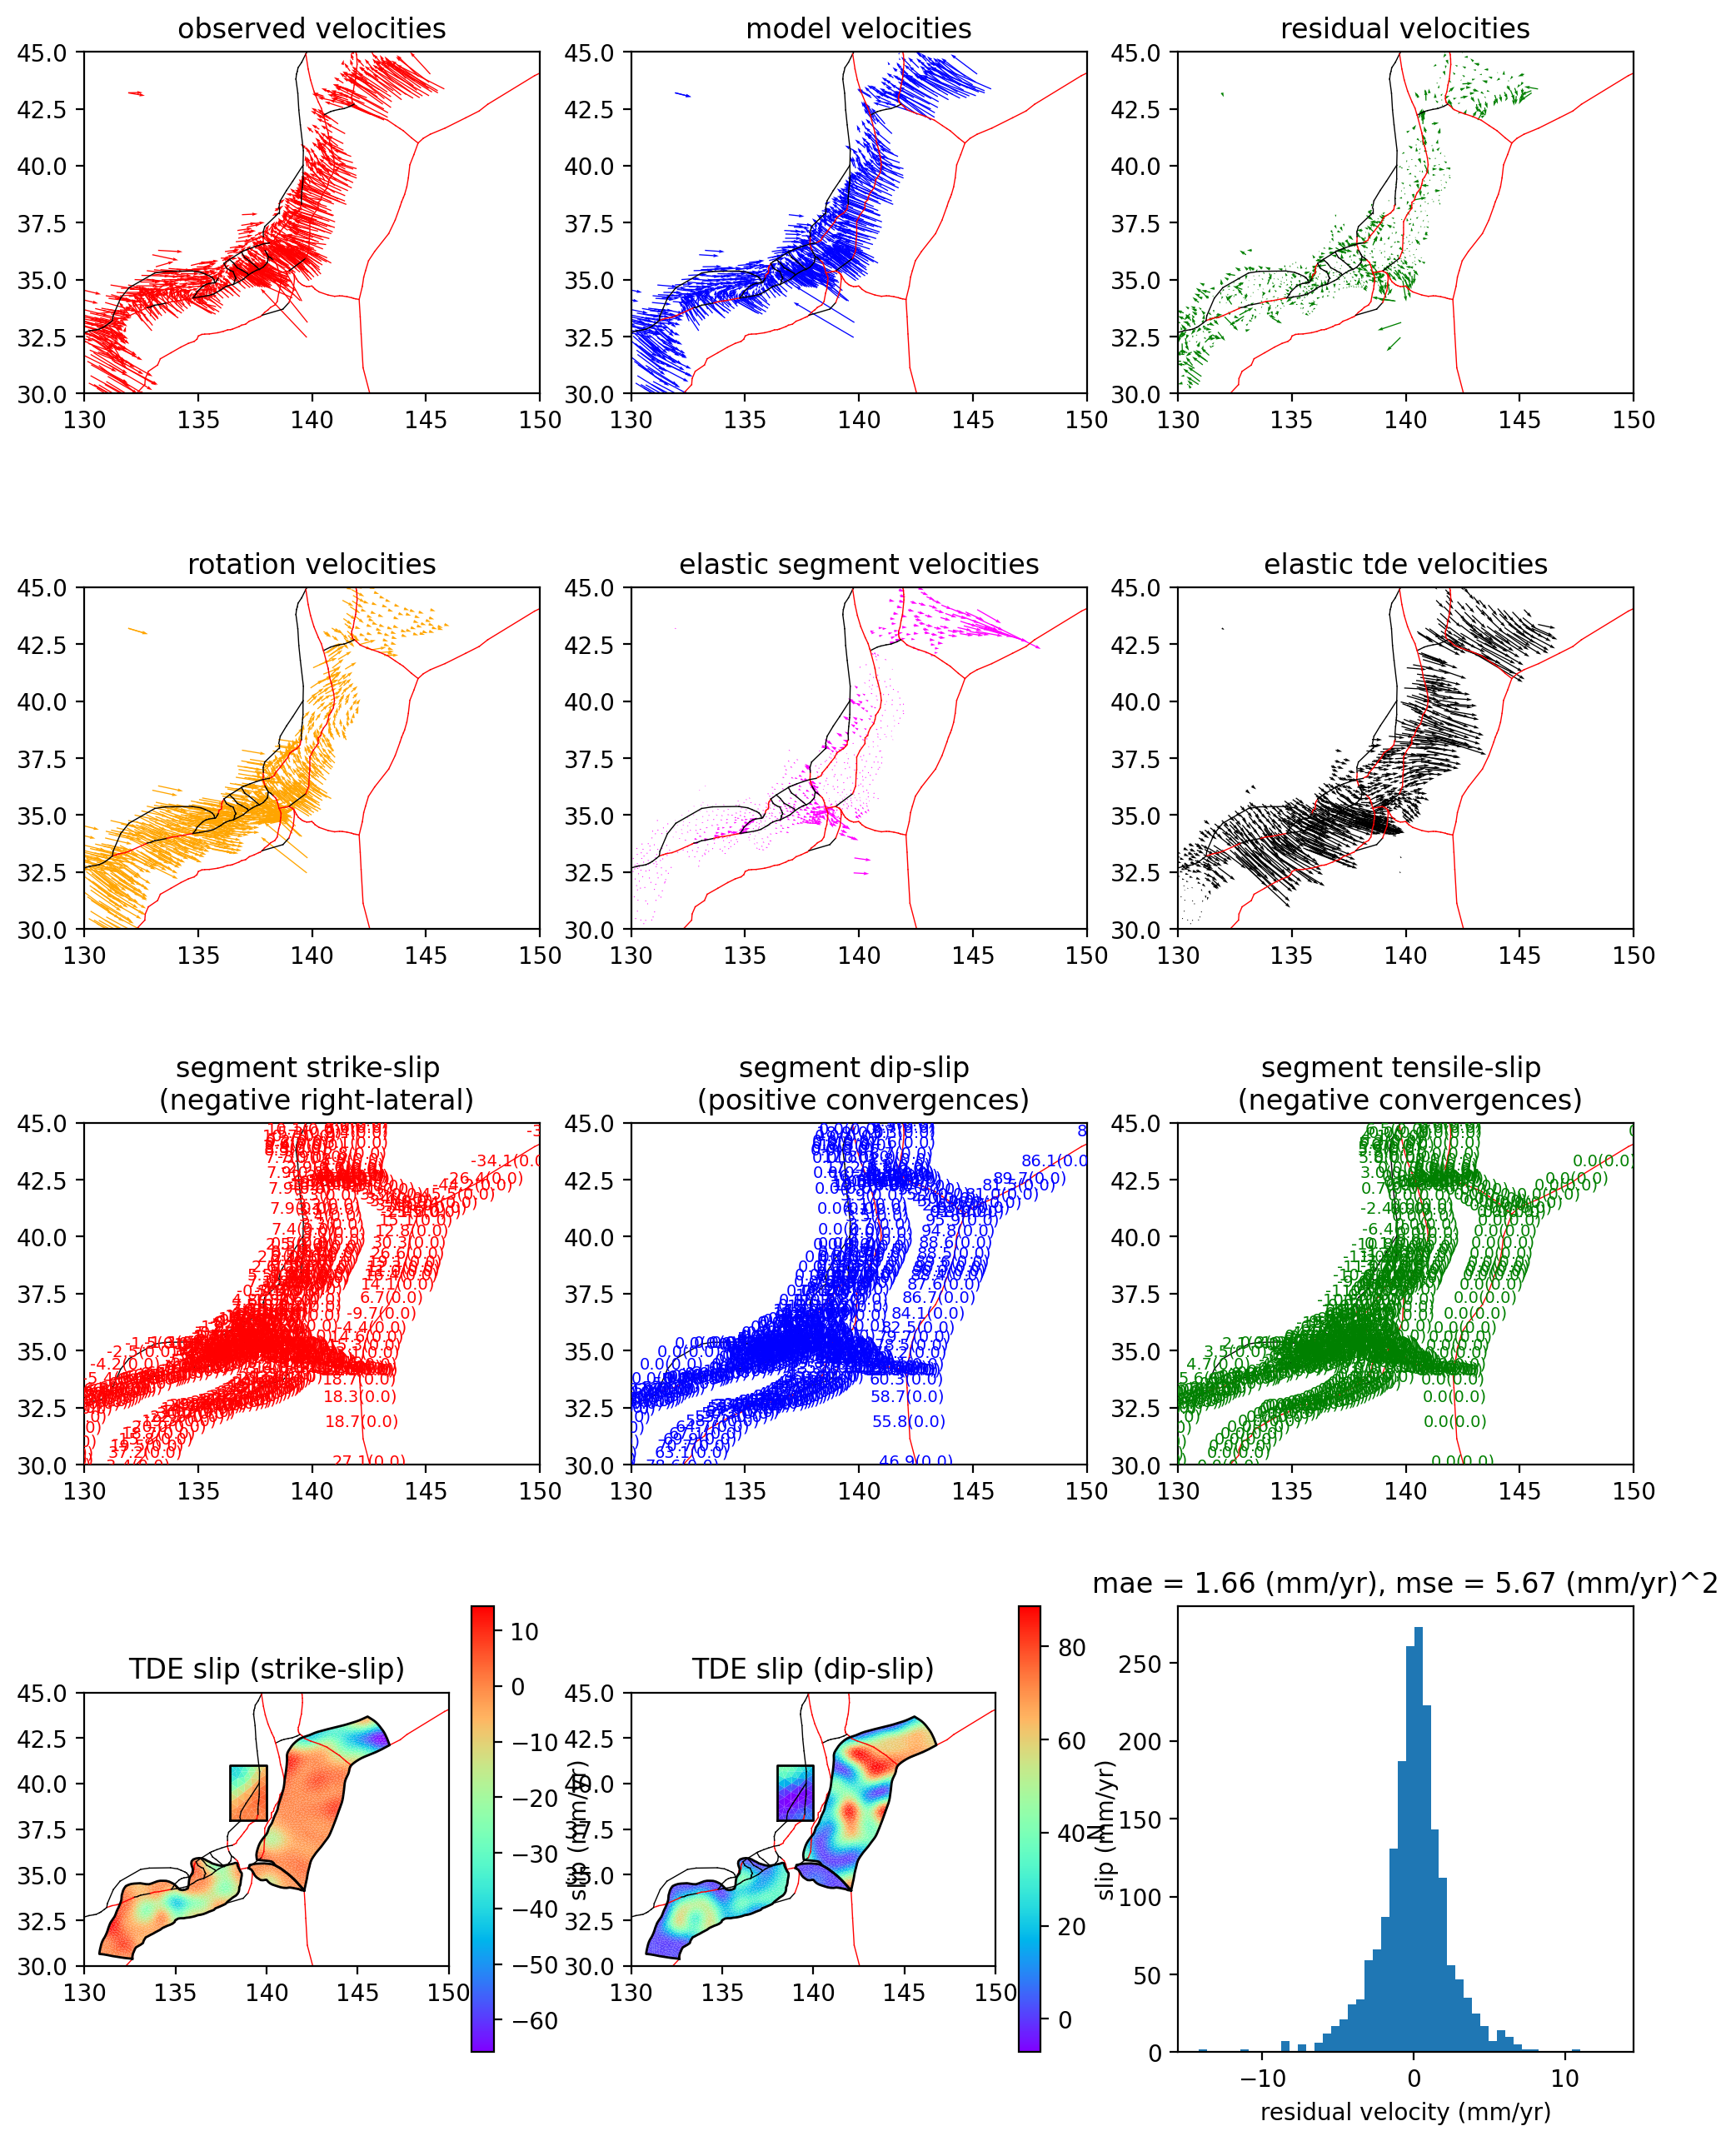

<Figure size 640x480 with 0 Axes>

In [ ]:





trace_japan.minimizer.plot_estimation_summary(problem.command)

In [8]:
from celeri.celeri import post_process_estimation_eigen
import addict

estimation_qp = addict.Dict()
estimation_qp.state_vector = trace_japan.minimizer.params.value
estimation_qp.operator = trace_japan.minimizer.problem.operators.eigen
post_process_estimation_eigen(
    estimation_qp,
    trace_japan.minimizer.problem.operators,
    trace_japan.minimizer.problem.station,
    trace_japan.minimizer.problem.index,
)

In [9]:
# Create a new figure

import matplotlib

segment = problem.command.segment
lon_range = problem.command.lon_range
lat_range = problem.command.lat_range
meshes = problem.meshes

def common_plot_elements(segment: pd.DataFrame, lon_range: tuple, lat_range: tuple):
    """Elements common to all subplots.

    Args:
        segment (pd.DataFrame): Fault segments
        lon_range (Tuple): Longitude range (min, max)
        lat_range (Tuple): Latitude range (min, max)
    """
    for i in range(len(segment)):
        if segment.dip[i] == 90.0:
            plt.plot(
                [segment.lon1[i], segment.lon2[i]],
                [segment.lat1[i], segment.lat2[i]],
                "-k",
                linewidth=0.5,
            )
        else:
            plt.plot(
                [segment.lon1[i], segment.lon2[i]],
                [segment.lat1[i], segment.lat2[i]],
                "-r",
                linewidth=0.5,
            )

    plt.xlim([lon_range[0], lon_range[1]])
    plt.ylim([lat_range[0], lat_range[1]])
    plt.gca().set_aspect("equal", adjustable="box")

In [95]:
meshes[0].n_tde + meshes[1].n_tde + meshes[2].n_tde

4754

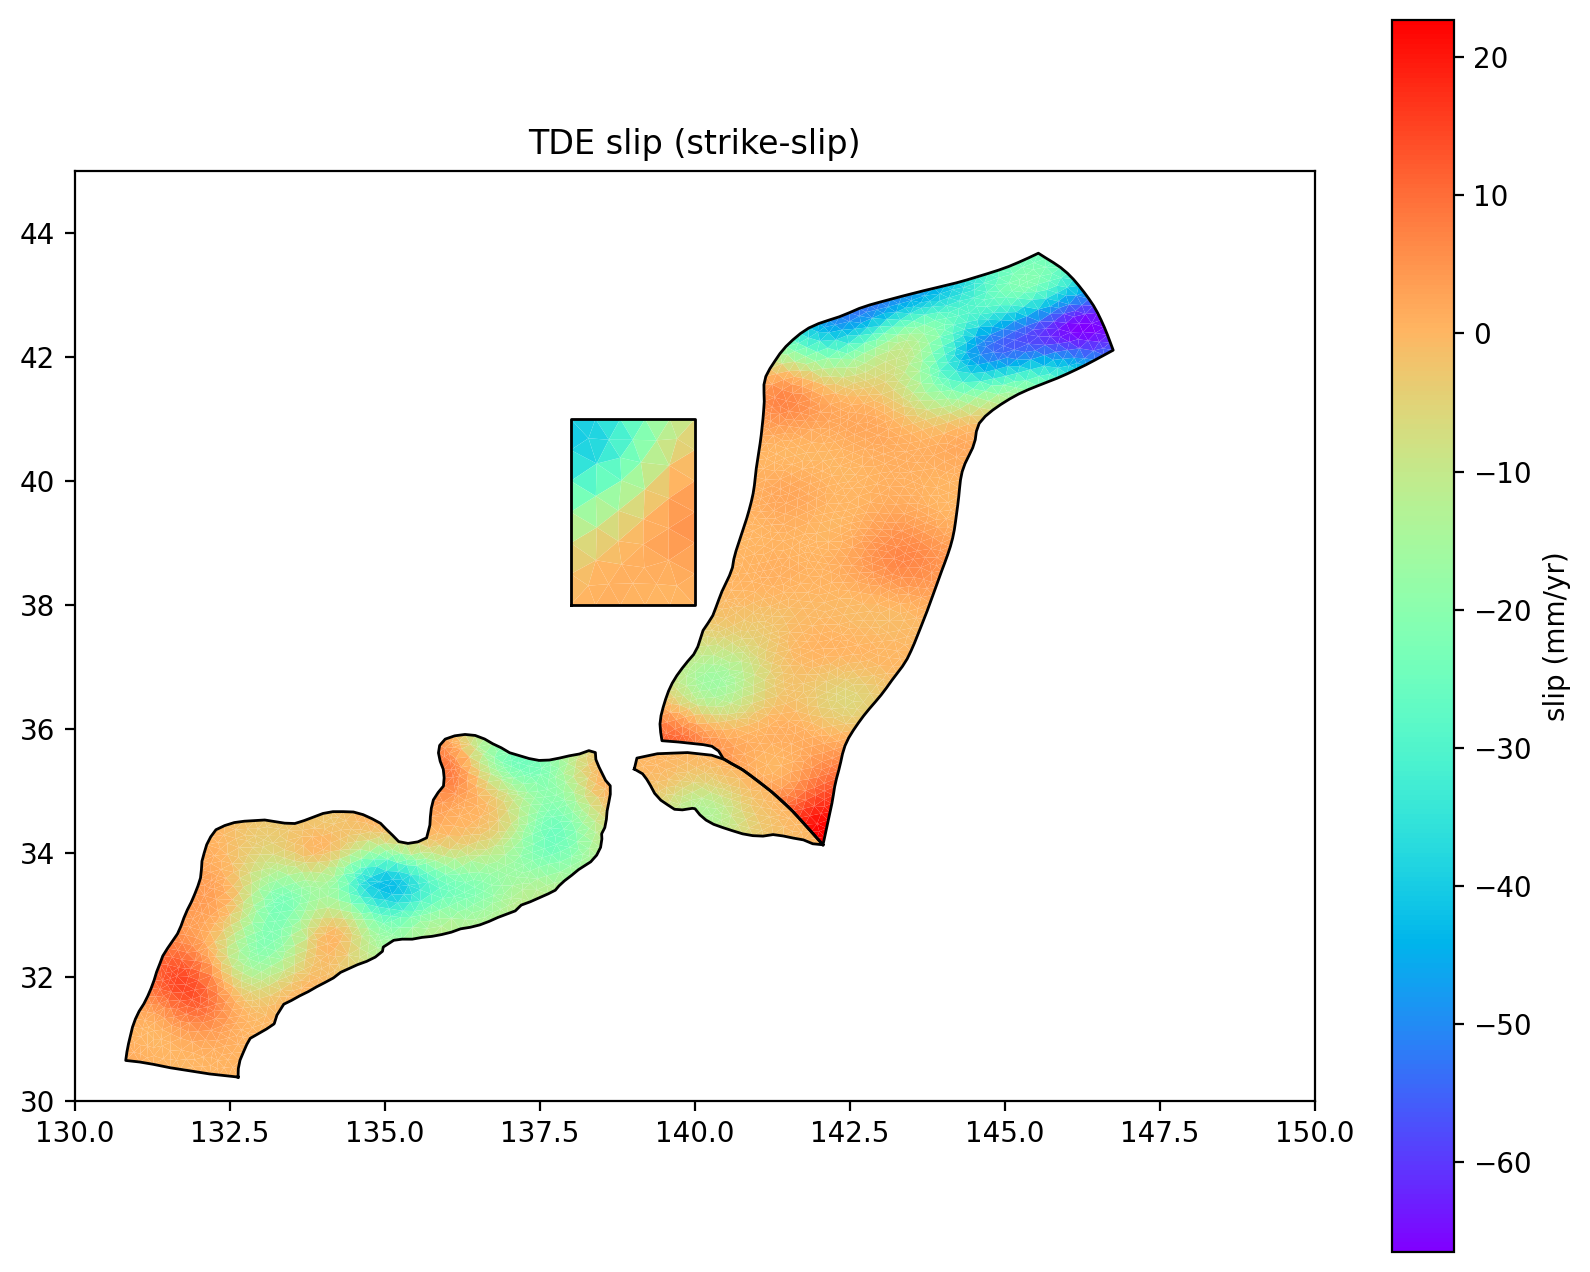

In [97]:
plt.figure(figsize=(10, 8))

plt.title("TDE slip (strike-slip)")
common_plot_elements(segment, lon_range, lat_range)

estimation = estimation_qp
fill_value = estimation.tde_strike_slip_rates
fill_value_range = [np.min(fill_value), np.max(fill_value)]
ax = plt.gca()

for i in range(len(meshes)):
    x_coords = meshes[i].points[:, 0]
    y_coords = meshes[i].points[:, 1]
    vertex_array = np.asarray(meshes[i].verts)

    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts, edgecolor="none", cmap="rainbow"
    )
    
    if i == 0:
        tde_slip_component_start = 0
        tde_slip_component_end = meshes[i].n_tde
    else:
        tde_slip_component_start = tde_slip_component_end
        tde_slip_component_end = tde_slip_component_start + meshes[i].n_tde
    
    pc.set_array(
        fill_value[tde_slip_component_start:tde_slip_component_end]
    )
    pc.set_clim(fill_value_range)
    ax.add_collection(pc)
    
    if i == len(meshes) - 1:
        plt.colorbar(pc, label="slip (mm/yr)")

    # Add mesh edge
    x_edge = x_coords[meshes[i].ordered_edge_nodes[:, 0]]
    y_edge = y_coords[meshes[i].ordered_edge_nodes[:, 0]]
    x_edge = np.append(x_edge, x_coords[meshes[0].ordered_edge_nodes[0, 0]])
    y_edge = np.append(y_edge, y_coords[meshes[0].ordered_edge_nodes[0, 0]])
    plt.plot(x_edge, y_edge, color="black", linewidth=1)

In [10]:
def make_plot(fill_value, create_figure=True):
    if create_figure:
        plt.figure(figsize=(20, 16))
        plt.title("TDE slip (strike-slip)")

    common_plot_elements(segment, lon_range, lat_range)

    # fill_value = estimation.tde_strike_slip_rates
    # fill_value_range = [np.min(fill_value), np.max(fill_value)]
    fill_value_range = [-10, 10]  # Set fixed range from -10 to 10
    ax = plt.gca()

    # Create a regular grid for contouring
    x_min, x_max = lon_range
    y_min, y_max = lat_range
    grid_resolution = 200  # Adjust this for finer/coarser contours
    x_grid = np.linspace(x_min, x_max, grid_resolution)
    y_grid = np.linspace(y_min, y_max, grid_resolution)
    X, Y = np.meshgrid(x_grid, y_grid)

    # Initialize the interpolated values grid
    Z = np.zeros_like(X)

    # Interpolate values onto the grid
    for i in range(len(meshes)):
        x_coords = meshes[i].points[:, 0]
        y_coords = meshes[i].points[:, 1]
        vertex_array = np.asarray(meshes[i].verts)

        xy = np.c_[x_coords, y_coords]
        verts = xy[vertex_array]
        pc = matplotlib.collections.PolyCollection(
            verts, edgecolor="none", cmap="rainbow"
        )
        
        if i == 0:
            tde_slip_component_start = 0
            tde_slip_component_end = meshes[i].n_tde
        else:
            tde_slip_component_start = tde_slip_component_end
            tde_slip_component_end = tde_slip_component_start + meshes[i].n_tde
        
        # Get the slip values for this mesh
        mesh_values = fill_value[tde_slip_component_start:tde_slip_component_end]
        
        # Create a triangulation for this mesh
        tri = matplotlib.tri.Triangulation(x_coords, y_coords, vertex_array)
        
        # For each point in our grid, find which triangle it belongs to and interpolate
        for ix in range(grid_resolution):
            for iy in range(grid_resolution):
                x = X[ix, iy]
                y = Y[ix, iy]
                
                # Find which triangle contains this point
                triangle_idx = tri.get_trifinder()(x, y)
                if triangle_idx != -1:  # Point is inside a triangle
                    # Get the vertices of the triangle
                    v1, v2, v3 = vertex_array[triangle_idx]
                    
                    # Get the coordinates of the triangle vertices
                    x1, y1 = x_coords[v1], y_coords[v1]
                    x2, y2 = x_coords[v2], y_coords[v2]
                    x3, y3 = x_coords[v3], y_coords[v3]
                    
                    # Calculate barycentric coordinates
                    denominator = ((y2 - y3)*(x1 - x3) + (x3 - x2)*(y1 - y3))
                    w1 = ((y2 - y3)*(x - x3) + (x3 - x2)*(y - y3)) / denominator
                    w2 = ((y3 - y1)*(x - x3) + (x1 - x3)*(y - y3)) / denominator
                    w3 = 1 - w1 - w2
                    
                    # Interpolate the value
                    Z[ix, iy] = mesh_values[triangle_idx]
        
        pc.set_array(mesh_values)
        pc.set_clim(fill_value_range)
        ax.add_collection(pc)
        
        if i == len(meshes) - 1:
            plt.colorbar(pc, label="slip (mm/yr)")

        # Add mesh edge
        x_edge = x_coords[meshes[i].ordered_edge_nodes[:, 0]]
        y_edge = y_coords[meshes[i].ordered_edge_nodes[:, 0]]
        x_edge = np.append(x_edge, x_coords[meshes[0].ordered_edge_nodes[0, 0]])
        y_edge = np.append(y_edge, y_coords[meshes[0].ordered_edge_nodes[0, 0]])
        plt.plot(x_edge, y_edge, color="black", linewidth=1)

    # Plot the zero contour
    plt.contour(X, Y, Z, levels=[0], colors='black', linewidths=2, linestyles='--')

In [85]:
from IPython.display import display
from ipywidgets import IntSlider, interact

def make_plot_with_slider(n):
    estimation_qp = addict.Dict()
    estimation_qp.state_vector = trace_japan.params[n]
    estimation_qp.operator = trace_japan.minimizer.problem.operators.eigen
    post_process_estimation_eigen(
        estimation_qp,
        trace_japan.minimizer.problem.operators,
        trace_japan.minimizer.problem.station,
        trace_japan.minimizer.problem.index,
    )

    estimation = estimation_qp
    plt.figure(figsize=(20, 16))
    plt.title(f"TDE slip (strike-slip) - State {n}")
    make_plot(estimation.tde_strike_slip_rates, create_figure=False)
    plt.show()

# Create the interactive widget
interact(
    make_plot_with_slider,
    n=IntSlider(
        min=0,
        max=len(trace_japan.params)-1,
        step=1,
        description='State:',
        continuous_update=False
    )
);

interactive(children=(IntSlider(value=0, continuous_update=False, description='State:', max=12), Output()), _d…

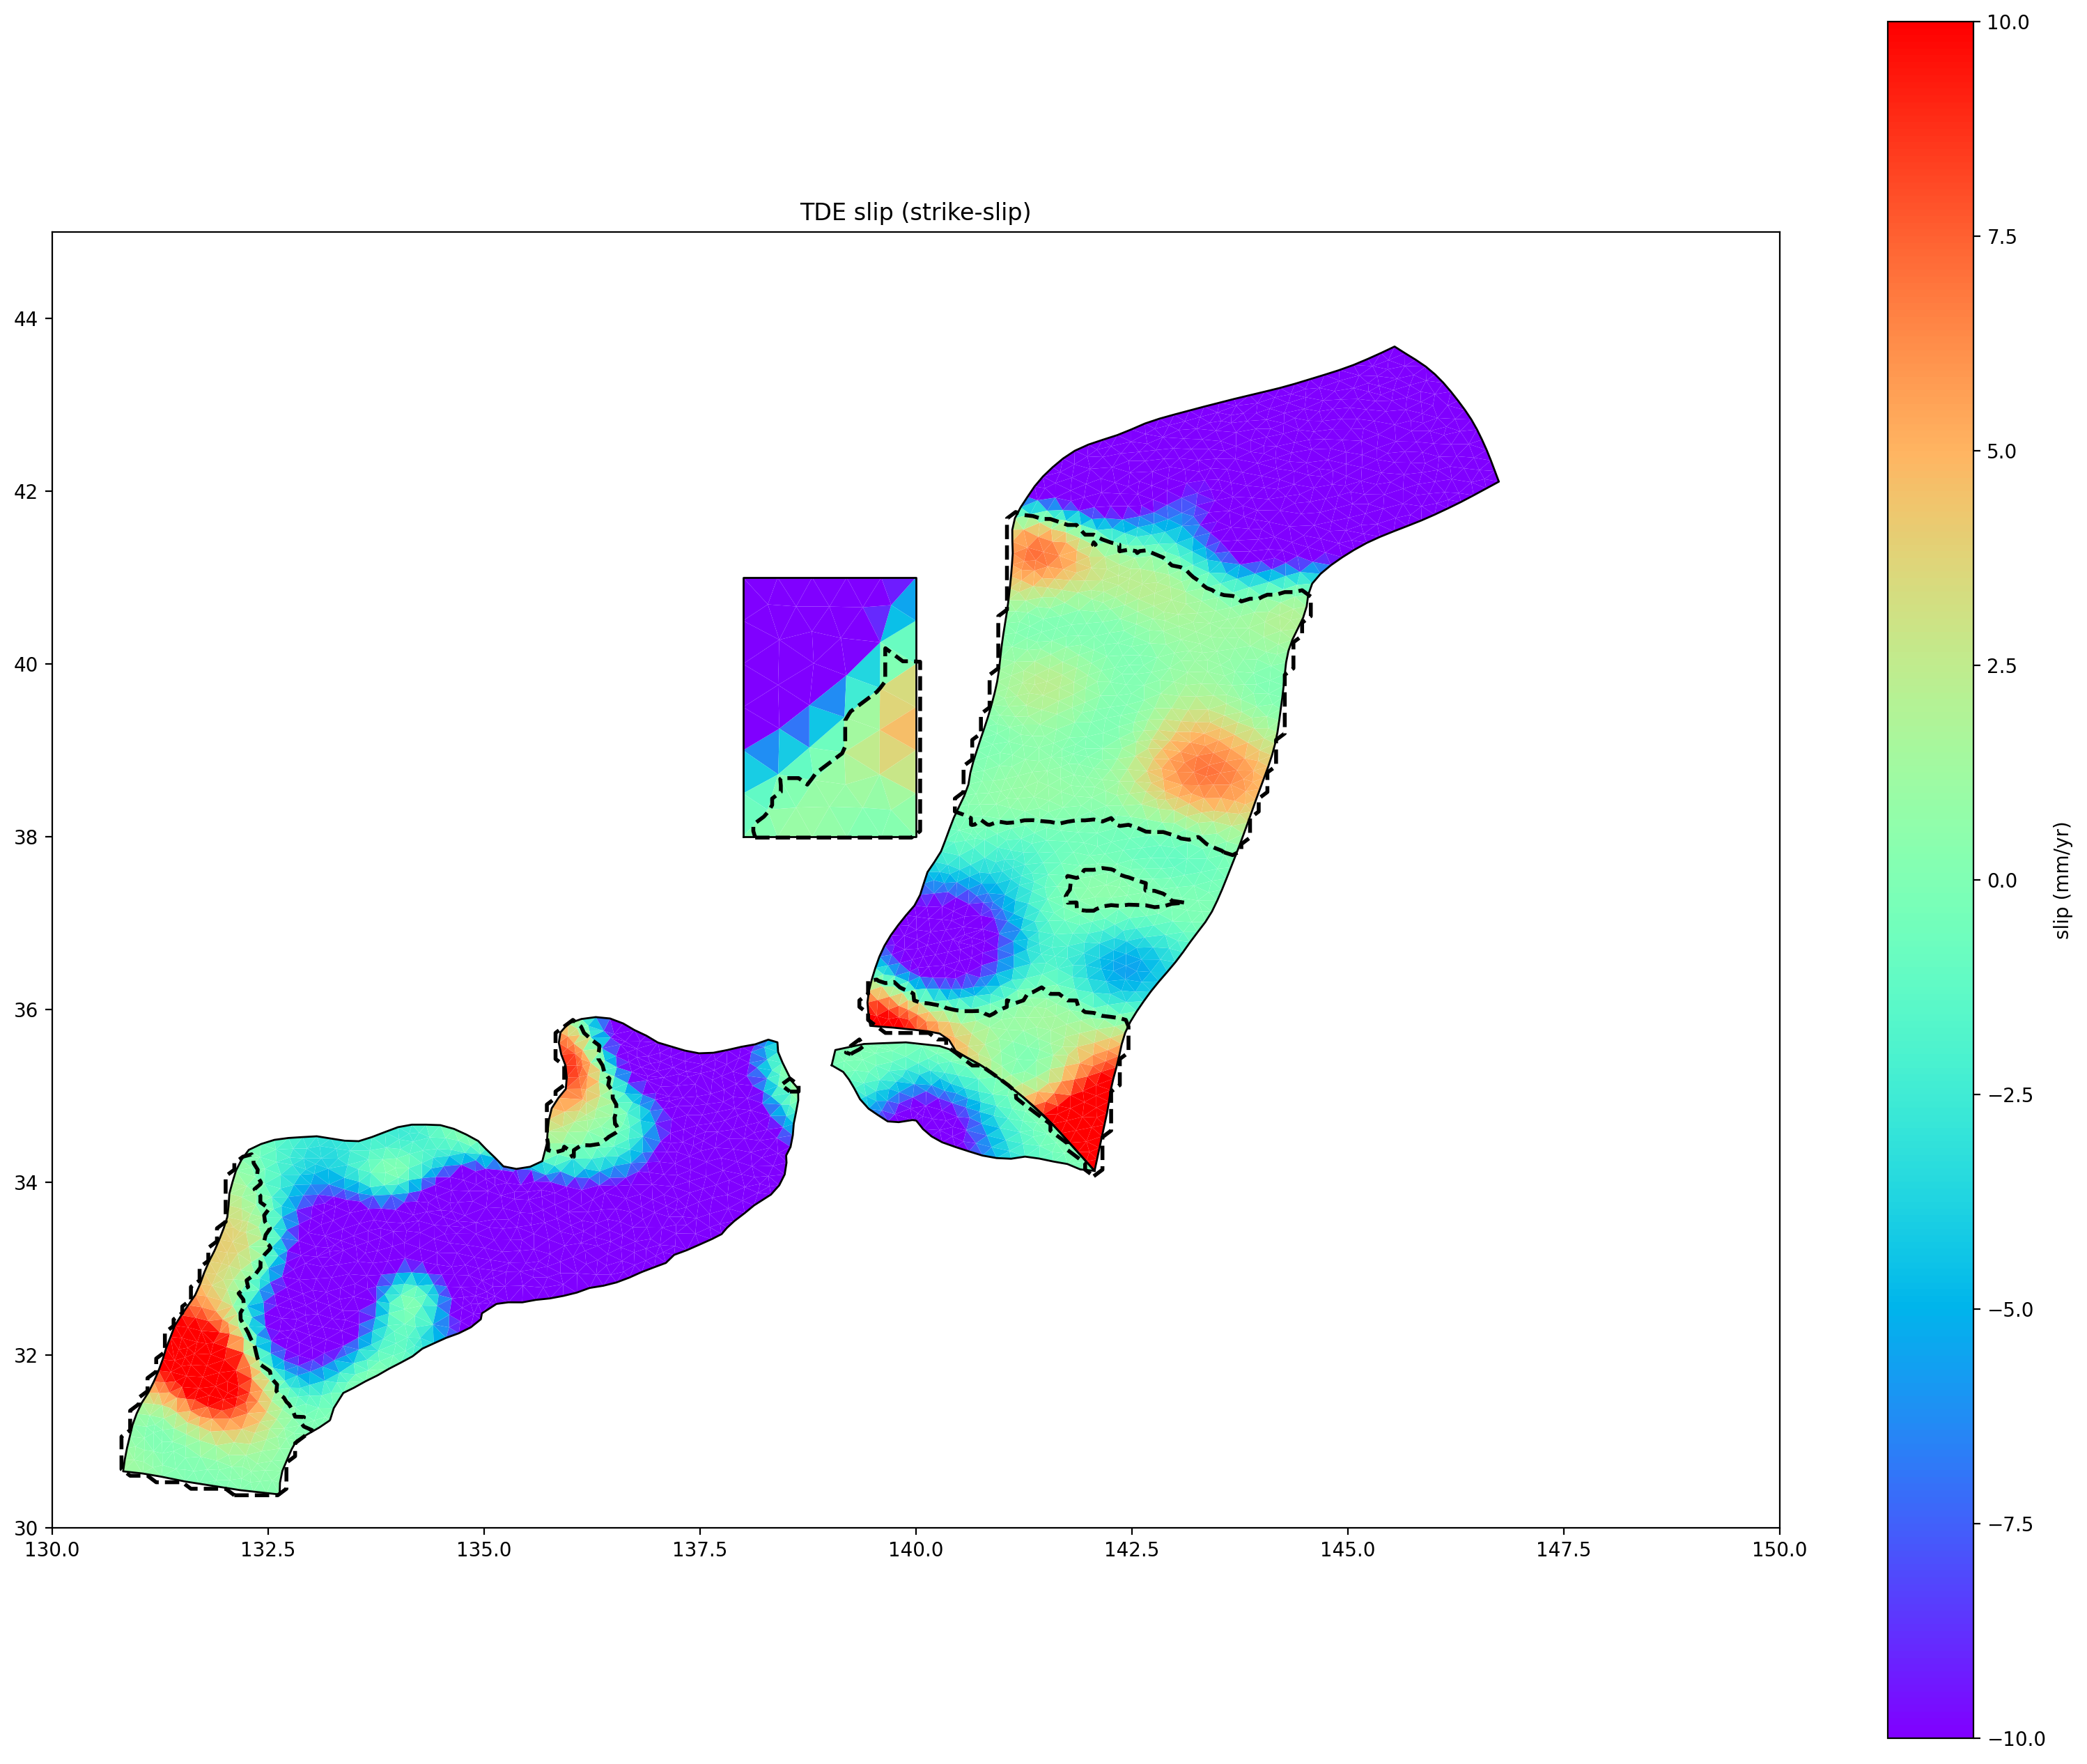

In [89]:

estimation_qp = addict.Dict()
estimation_qp.state_vector = trace_japan.params[5]
estimation_qp.operator = trace_japan.minimizer.problem.operators.eigen
post_process_estimation_eigen(
    estimation_qp,
    trace_japan.minimizer.problem.operators,
    trace_japan.minimizer.problem.station,
    trace_japan.minimizer.problem.index,
)

estimation = estimation_qp

make_plot(estimation.tde_strike_slip_rates)

In [19]:
trace_japan.objective_norm2

[np.float64(34.90583079498873),
 np.float64(37.30332788820176),
 np.float64(39.97139016711787),
 np.float64(41.337334882338524),
 np.float64(42.095549891960964),
 np.float64(42.311356126764856),
 np.float64(42.47144951228623),
 np.float64(42.60519437798887),
 np.float64(42.65434711862471),
 np.float64(42.730132562083504),
 np.float64(42.75133000736973),
 np.float64(42.751507411058675),
 np.float64(42.74860926501867),
 np.float64(38.418085023567535),
 np.float64(40.66560062999695),
 np.float64(41.90901299533602),
 np.float64(42.23497977175788),
 np.float64(42.42214001997028),
 np.float64(42.5231999999888),
 np.float64(42.62198216391384),
 np.float64(42.69936974505596),
 np.float64(42.74015180217177),
 np.float64(42.75016461177273),
 np.float64(42.75327328362914),
 np.float64(42.753248031645),
 np.float64(40.12931339583498),
 np.float64(41.70582304648595),
 np.float64(42.21506254780059),
 np.float64(42.422518243913466),
 np.float64(42.53135011223272),
 np.float64(42.61386543731032),
 np.

In [17]:
trace_japan.out_of_bounds

[np.int64(5133),
 np.int64(4186),
 np.int64(2179),
 np.int64(993),
 np.int64(409),
 np.int64(209),
 np.int64(99),
 np.int64(51),
 np.int64(31),
 np.int64(20),
 np.int64(5),
 np.int64(1),
 np.int64(0),
 np.int64(3373),
 np.int64(1573),
 np.int64(612),
 np.int64(238),
 np.int64(116),
 np.int64(66),
 np.int64(31),
 np.int64(20),
 np.int64(8),
 np.int64(5),
 np.int64(2),
 np.int64(0),
 np.int64(2032),
 np.int64(701),
 np.int64(258),
 np.int64(120),
 np.int64(65),
 np.int64(36),
 np.int64(18),
 np.int64(8),
 np.int64(2),
 np.int64(1),
 np.int64(0),
 np.int64(1006),
 np.int64(302),
 np.int64(134),
 np.int64(64),
 np.int64(38),
 np.int64(20),
 np.int64(6),
 np.int64(2),
 np.int64(1),
 np.int64(0),
 np.int64(451),
 np.int64(160),
 np.int64(71),
 np.int64(42),
 np.int64(22),
 np.int64(5),
 np.int64(2),
 np.int64(0),
 np.int64(218),
 np.int64(79),
 np.int64(44),
 np.int64(19),
 np.int64(9),
 np.int64(8),
 np.int64(2),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(119),
 np.in

In [37]:
[(n, trace_japan.objective_norm2[n]) for n in range(len(trace_japan.params)) if trace_japan.out_of_bounds[n] == 0]

[(12, np.float64(42.74860926501867)),
 (19, np.float64(42.73993278022447)),
 (23, np.float64(42.73774614290927)),
 (31, np.float64(42.737322658651266))]

In [ ]:
[(n, trace_japan.objective_norm2[n]) for n in range(len(trace_japan.params)) if trace_japan.out_of_bounds[n] == 0]

[(12, np.float64(42.74860926501867)),
 (21, np.float64(42.73955301805384)),
 (31, np.float64(42.73733186733481)),
 (36, np.float64(42.737317450844806))]

In [ ]:
[(n, trace_japan.objective_norm2[n]) for n in range(len(trace_japan.params)) if trace_japan.out_of_bounds[n] == 0]

[(12, np.float64(42.74860926501867)),
 (21, np.float64(42.739516690393124)),
 (31, np.float64(42.73733186436606)),
 (35, np.float64(42.737317450844806))]

In [ ]:
[(n, trace_japan.objective_norm2[n]) for n in range(len(trace_japan.params)) if trace_japan.out_of_bounds[n] == 0]

[(12, np.float64(42.74860926501867)),
 (21, np.float64(42.739516690393124)),
 (32, np.float64(42.73732898467087)),
 (37, np.float64(42.737317450844806))]

In [ ]:
[(n, trace_japan.objective_norm2[n]) for n in range(len(trace_japan.params)) if trace_japan.out_of_bounds[n] == 0]

[(12, np.float64(42.74860926501867)),
 (22, np.float64(42.738971961041315)),
 (33, np.float64(42.73732770637272)),
 (40, np.float64(42.737317450844806)),
 (46, np.float64(42.737317450844806))]

In [ ]:
[(n, trace_japan.objective_norm2[n]) for n in range(len(trace_japan.params)) if trace_japan.out_of_bounds[n] == 0]

[(12, np.float64(42.74860926501867)),
 (24, np.float64(42.753248031645)),
 (35, np.float64(42.747924398620576)),
 (45, np.float64(42.74775954803366)),
 (53, np.float64(42.74062899173406)),
 (64, np.float64(42.73733040276304)),
 (72, np.float64(42.737317450844806)),
 (80, np.float64(42.737317450844806)),
 (87, np.float64(42.737317450844806)),
 (93, np.float64(42.737317450844806))]

In [25]:
[(n, trace_japan.objective_norm2[n]) for n in range(len(trace_japan.params)) if trace_japan.out_of_bounds[n] == 0]

[(12, np.float64(42.74860926501867)),
 (24, np.float64(42.738532895867)),
 (36, np.float64(42.737322939464754)),
 (44, np.float64(42.737317450844806)),
 (52, np.float64(42.737317450844806)),
 (59, np.float64(42.737317450844806)),
 (65, np.float64(42.737317450844806))]

In [23]:
def save_plots(output_dir="plot_sequence"):
    # Create output directory if it doesn't exist
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Save each state as a PNG
    for n in range(len(trace_japan.params)):
        estimation_qp = addict.Dict()
        estimation_qp.state_vector = trace_japan.params[n]
        estimation_qp.operator = trace_japan.minimizer.problem.operators.eigen
        post_process_estimation_eigen(
            estimation_qp,
            trace_japan.minimizer.problem.operators,
            trace_japan.minimizer.problem.station,
            trace_japan.minimizer.problem.index,
        )

        estimation = estimation_qp
        plt.figure(figsize=(20, 16))
        num_oob = trace_japan.out_of_bounds[n]
        objective_norm2 = trace_japan.objective_norm2[n]
        plt.title(f"TDE slip (strike-slip) - State {n:02d} - {num_oob:04d} out of bounds - {objective_norm2:.8e}")
        make_plot(estimation.tde_strike_slip_rates, create_figure=False)
        
        # Save the plot
        plt.savefig(os.path.join(output_dir, f"state_{n:04d}.png"), dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Saved state {n}")

save_plots()

Saved state 0
Saved state 1
Saved state 2
Saved state 3
Saved state 4
Saved state 5
Saved state 6
Saved state 7
Saved state 8
Saved state 9
Saved state 10
Saved state 11
Saved state 12
Saved state 13
Saved state 14
Saved state 15
Saved state 16
Saved state 17
Saved state 18
Saved state 19
Saved state 20
Saved state 21
Saved state 22
Saved state 23
Saved state 24
Saved state 25
Saved state 26
Saved state 27
Saved state 28
Saved state 29
Saved state 30
Saved state 31
Saved state 32
Saved state 33
Saved state 34
Saved state 35
Saved state 36
Saved state 37
Saved state 38
Saved state 39
Saved state 40
Saved state 41
Saved state 42
Saved state 43
Saved state 44
Saved state 45
Saved state 46
Saved state 47
Saved state 48
Saved state 49
Saved state 50
Saved state 51
Saved state 52
Saved state 53
Saved state 54
Saved state 55
Saved state 56
Saved state 57
Saved state 58
Saved state 59
Saved state 60
Saved state 61
Saved state 62
Saved state 63
Saved state 64
Saved state 65
Saved state 66
Saved

In [49]:
xx = np.arange(30)
x0 = xx[0::3]
x1 = xx[1::3]
x2 = xx[2::3]
xa = np.stack([x0, x1, x2])
xx = np.reshape(xa)

TypeError: reshape() missing 1 required positional argument: 'shape'

In [50]:
xa[1,2]

np.int64(7)

In [61]:
trace_japan.params[-1].shape

(299,)

In [ ]:
trace_japan.coupling[12]

In [58]:
trace_japan.minimizer.params.value.shape

(299,)

In [ ]:
from celeri.optimize import Coupling


In [55]:
trace_japan.coupling[12][0]

Coupling(strike_slip=CouplingItem(kinematic=array([  2.31807477,  -0.45631342,   2.82264145, ..., -30.85627891,
       -34.62241895, -34.6415831 ], shape=(1902,)), kinematic_smooth=array([ -5.03791051,  -4.63022951,  -3.17882931, ..., -22.99577218,
       -33.8380195 , -34.33362775], shape=(1902,)), estimated=array([ -3.68932443,  -2.81728171,  -1.51072858, ..., -12.3880888 ,
        -6.29667481,  -6.25705174], shape=(1902,))), dip_slip=CouplingItem(kinematic=array([44.19634186, 44.62879481, 45.16666505, ..., 15.26260875,
       41.98661755, 41.79271473], shape=(1902,)), kinematic_smooth=array([36.13199124, 35.49549192, 35.63672829, ..., 22.08572808,
       41.17069389, 40.81324334], shape=(1902,)), estimated=array([3.52742272e+01, 3.49011616e+01, 3.48013521e+01, ...,
       1.96701623e-02, 5.56730135e+00, 3.61944068e+00], shape=(1902,))))

In [96]:
1902+2621+231

4754

In [56]:
4830-(1902+2621+231)

76

In [46]:
trace_japan.coupling[12][0]

AttributeError: 'Coupling' object has no attribute 'keys'

In [45]:
estimation.tde_strike_slip_rates.shape

(4830,)

In [6]:
trace_japan.minimizer

NameError: name 'trace_japan' is not defined

### North America

In [ ]:
%%time
problem = celeri.optimize.build_problem(command_files["north_america"])

In [ ]:
%%time
solve_kwargs = dict(
    solver="CLARABEL",
    equilibrate_enable=False,
    direct_solve_method="faer",
    ignore_dpp=True,
)

trace_japan = celeri.optimize.minimize(
    problem,
    verbose=True,
    velocity_upper=110.0,
    velocity_lower=-110.0,
    solve_kwargs=solve_kwargs,
    objective="qr_sum_of_squares",
)